# Analysis of the Italy's national team that participated at the Euro 2016

## Load libraries

In [1]:
from analyzes import generate_pass_network, compute_pass_lines
from collections import defaultdict
from mplsoccer import Pitch, VerticalPitch
from pandas import json_normalize
#from utils.pitch import *
from utils.utils import get_player_positions, get_passes_by_players, transform_coordinate
from utils.viz import draw_pass_network

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

## Load data

In [2]:
# load teams
with open(f'data/teams.json') as f:
    teams = json.load(f)
# convert to a pandas' dataframe
teams_df = json_normalize(teams, sep = "_")

In [3]:
# add id of teams as index
teams_df.set_index(teams_df['wyId'].values, inplace=True)

In [4]:
teams_df.head()

,city,name,wyId,officialName,type,area_name,area_id,area_alpha3code,area_alpha2code
1613,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,club,England,0,XEN,
692,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,club,Spain,724,ESP,ES
691,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,club,Spain,724,ESP,ES
696,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,club,Spain,724,ESP,ES
695,Valencia,Levante,695,Levante UD,club,Spain,724,ESP,ES


In [5]:
# load matches of the competition of interest
competition = 'European_Championship'
with open(f'data/matches/matches_{competition}.json') as f:
    matches = json.load(f)

In [6]:
print(f'There were {len(matches)} matches in the {competition.replace("_"," ")}')

There were 51 matches in the European Championship


In [7]:
# load events of the competition of interest
with open(f'data/events/events_{competition}.json') as f:
    events = json.load(f)

In [8]:
print(f'There were {len(events)} events in {len(matches)} matches of the {competition.replace("_", " ")}')

There were 78140 events in 51 matches of the European Championship


In [9]:
# load players
with open(f'data/players.json') as f:
    players = json.load(f)
    # convert to a pandas' dataframe
    players_df = json_normalize(players, sep = "_")

In [10]:
# add id of players as index
players_df.set_index(players_df['wyId'].values, inplace=True)

In [11]:
players_df.columns

Index(['weight', 'firstName', 'middleName', 'lastName', 'currentTeamId',
       'birthDate', 'height', 'wyId', 'foot', 'shortName',
       'currentNationalTeamId', 'passportArea_name', 'passportArea_id',
       'passportArea_alpha3code', 'passportArea_alpha2code', 'role_code2',
       'role_code3', 'role_name', 'birthArea_name', 'birthArea_id',
       'birthArea_alpha3code', 'birthArea_alpha2code'],
      dtype='object')

In [12]:
# Decode unicode characters
players_df['lastName'] = players_df['lastName'].apply(lambda x: x.encode('ascii', 'strict').decode('unicode-escape'))
players_df['firstName'] = players_df['firstName'].apply(lambda x: x.encode('ascii', 'strict').decode('unicode-escape'))
players_df['shortName'] = players_df['shortName'].apply(lambda x: x.encode('ascii', 'strict').decode('unicode-escape'))

In [13]:
players_df.head()

,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,...,passportArea_id,passportArea_alpha3code,passportArea_alpha2code,role_code2,role_code3,role_name,birthArea_name,birthArea_id,birthArea_alpha3code,birthArea_alpha2code
32777,78,Harun,,Tekin,4502,1989-06-17,187,32777,right,H. Tekin,...,792,TUR,TR,GK,GKP,Goalkeeper,Turkey,792,TUR,TR
393228,73,Malang,,Sarr,3775,1999-01-23,182,393228,left,M. Sarr,...,686,SEN,SN,DF,DEF,Defender,France,250,FRA,FR
393230,72,Over,,Mandanda,3772,1998-10-26,176,393230,,O. Mandanda,...,250,FRA,FR,GK,GKP,Goalkeeper,France,250,FRA,FR
32793,82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,32793,right,A. N'Diaye,...,686,SEN,SN,MD,MID,Midfielder,France,250,FRA,FR
393247,84,Ibrahima,,Konaté,2975,1999-05-25,192,393247,right,I. Konaté,...,250,FRA,FR,DF,DEF,Defender,France,250,FRA,FR


## Process data

In [14]:
# select only national teams
national_teams = teams_df.loc[teams_df['type']=='national']

In [15]:
national_teams.head()

,city,name,wyId,officialName,type,area_name,area_id,area_alpha3code,area_alpha2code
14855,Seoul,Korea Republic,14855,Korea Republic,national,Korea Republic,410,KOR,KR
10451,Budapest,Hungary,10451,Hungary,national,Hungary,348,HUN,HU
4687,Istanbul,Turkey,4687,Turkey,national,Turkey,792,TUR,TR
14358,Moskva,Russia,14358,Russia,national,Russia,643,RUS,RU
7047,Solna,Sweden,7047,Sweden,national,Sweden,752,SWE,SE


### Process matches

In [16]:
euro_matches = defaultdict(dict)
for match in matches:
    euro_match = {
        'date': match['date'],
        'venue': match['venue'].encode('ascii', 'strict').decode('unicode-escape'),
        'roundId': match['roundId'],
        'label': match['label']
    }
    euro_match['teams'] = []
    for team_id in match['teamsData'].keys():
        team_dict = {
            'name': national_teams.loc[int(team_id)]['name'],
            'id': team_id,
            'side': match['teamsData'][team_id]['side']
        }
        scores = []
        lineup = []
        substitutions = []
        for key, value in match['teamsData'][team_id].items():
            if 'score' in key and key != 'scoreP':
                scores.append(value)
            if key == 'formation':
                for player in value['lineup']:
                    lineup.append(
                        {
                            'id': player['playerId'],
                            'name': players_df.loc[int(player['playerId'])]['shortName']
                        }
                    )
                for player in value['bench']:
                    substitutions.append(
                        {
                            'id': player['playerId'],
                            'name': players_df.loc[int(player['playerId'])]['shortName']
                        }
                    )
        team_dict['score'] = max(scores)
        team_dict['lineup'] = lineup
        team_dict['substitutions'] = substitutions
        euro_match['teams'].append(team_dict)
    euro_matches[match['wyId']] = euro_match


### Collect match's events

In [17]:
id_italy_matches = []
for match_id, match in euro_matches.items():
    if match['teams'][0]['name'] == 'Italy' or match['teams'][1]['name'] == 'Italy':
        id_italy_matches.append(match_id)

In [18]:
id_italy_matches

[1694436, 1694432, 1694418, 1694416, 1694415]

In [19]:
# Change
team_id = 3757 # Team id, Italy (3757), Belgium (5629), Sweden (7047), Ireland (8274), Spain (1598), Germany (3148)
team_name = teams_df.loc[team_id]['name'] # Team name
match_id = 1694436
team_color = [0,0,1,1]  # yellow [1, 1, 0, 1], red [1,0,0,1], blue [0,0,1,1], green [0,0.5,0,1], silver [0.75, 0.75, 0.75, 1]

In [20]:
match_events = []
for event in events:
    if event['matchId'] == match_id:
        match_events.append(event)

In [21]:
print(f'There were {len(match_events)} in the match {match_id}')

There were 1974 in the match 1694436


In [22]:
events_df = pd.DataFrame(match_events)

In [23]:
events_df['eventName'].value_counts()

Pass                  1291
Duel                   367
Others on the ball     125
Free Kick              115
Foul                    27
Shot                    24
Save attempt            23
Offside                  2
Name: eventName, dtype: int64

## Network of passes

### Create the network

In [24]:
team_passes = generate_pass_network(match_events, team_id, players_df)

### Draw network

#### Get match lineup

In [25]:
match_lineup = {}
for team in euro_matches[match_id]['teams']:
    if int(team['id']) == team_id:
        for player in team['lineup']:
            match_lineup[player['id']] = player['name']

#### Position of players during match

In [26]:
avg_positions = get_player_positions(match_events, team_id, players_df, 'Pass', coordinate_system_from=(100,100), 
                                     coordinate_system_to=(120,80), team_lineup = match_lineup)

#### Compute pass lines

In [27]:
lines, weights = compute_pass_lines(team_passes, avg_positions, min_num_passes=5, team_lineup=match_lineup)

#### Compute passes by players

In [28]:
passes_by_players = get_passes_by_players(match_events, team_id, players_df)

#### Draw pitch and passes

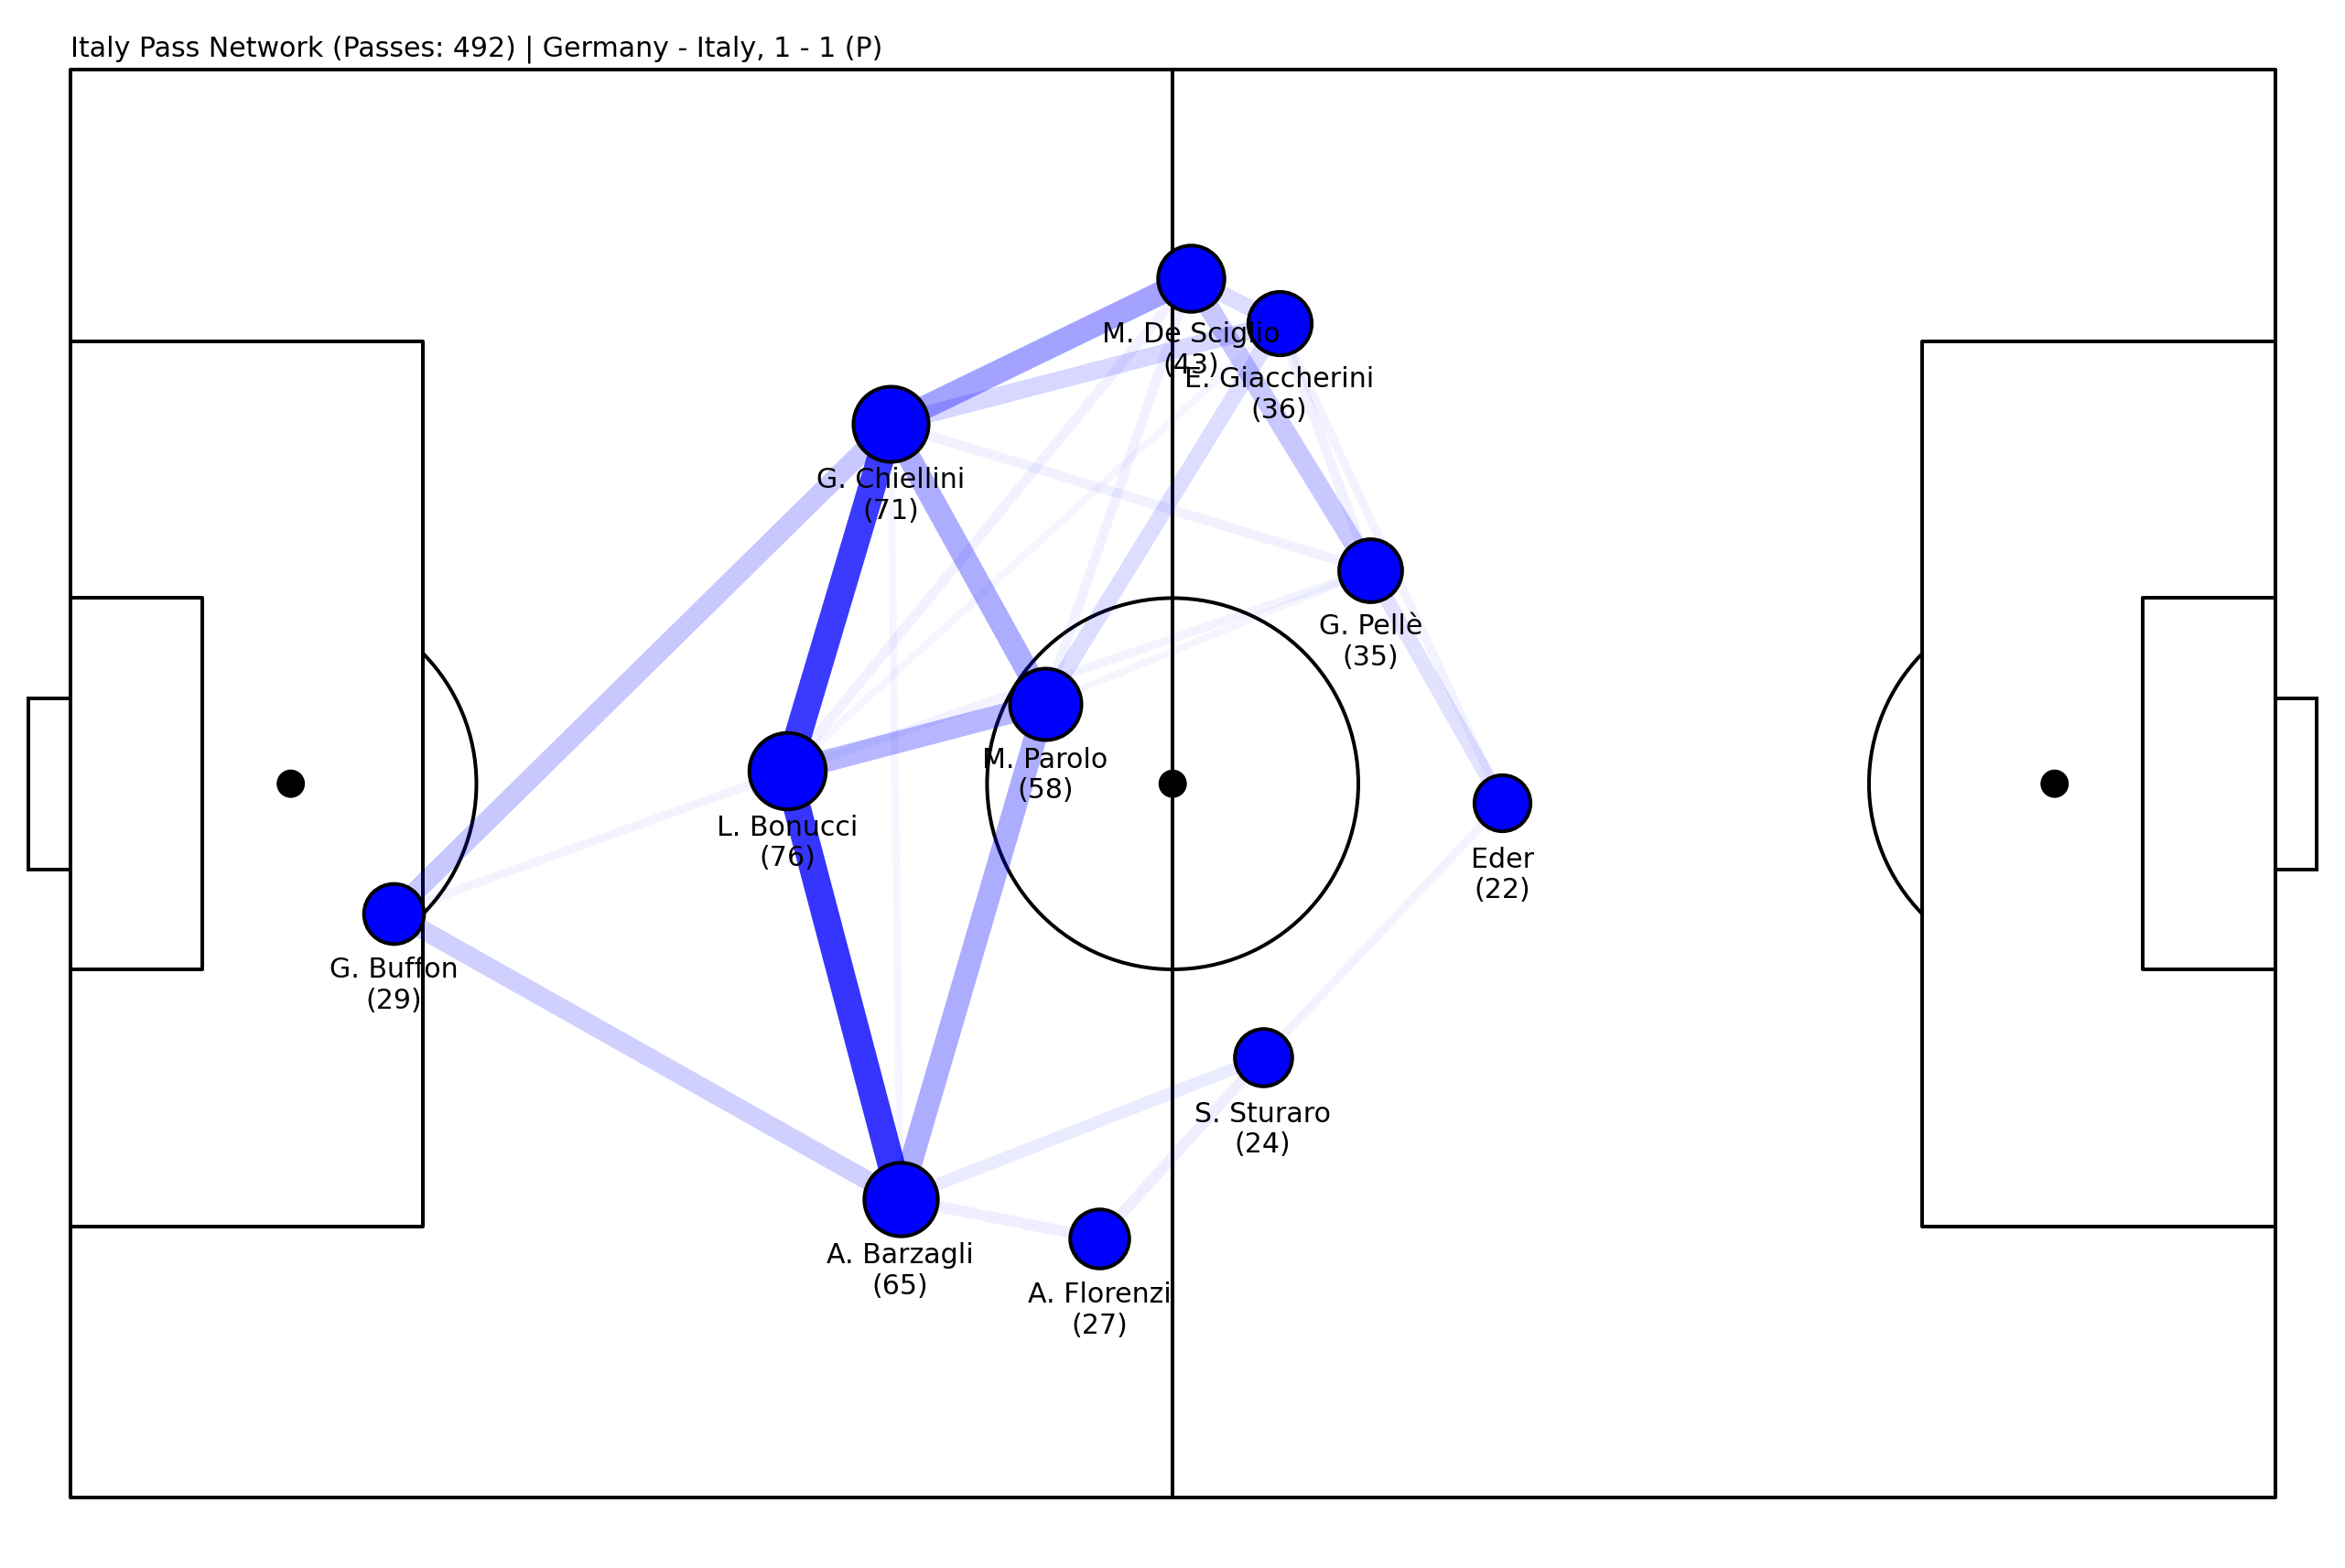

In [29]:
fig, ax = draw_pass_network(f"{team_name} Pass Network (Passes: {sum(passes_by_players.values())}) | {euro_matches[match_id]['label']}", 
                            lines, weights, avg_positions, passes_by_players, pitch_color='white', 
                            pitch_line_color='black', pitch_type='wyscout', pitch_line_width=2, linezorder=0, 
                            color=team_color)

In [30]:
match_label = euro_matches[match_id]['label']
file_name = f"{match_label.split(',')[0].replace('-','_').replace(' ','').lower()}_net_passes_{team_name.lower()}"
fig.savefig(f'figures/{file_name}.pdf', dpi=100)

## Pressure zones

Pressure is not recorded as event in Wyscout so some events will be used as proxies of pressure. In particular, the event **Duel** and its corresponding subevent **Ground attacking duel** are going to consider proxies for pressure. Foul events were analyzed to be included however not neccesarily pressure actions ended up in fouls and players can give away fouls without actually pressing their rivals. So, the best proxy among all possible events is duel-ground attaching duel. Visualization is based on https://github.com/Friends-of-Tracking-Data-FoTD/mapping-match-events-in-Python/blob/master/data_exploration.ipynb.

### Filter interested events

In [53]:
id_italy_matches

[1694436, 1694432, 1694418, 1694416, 1694415]

In [75]:
match_events = []
match_id = 1694436
for event in events:
    if event['matchId'] == match_id:
        match_events.append(event)

In [76]:
interested_events = []
for event in match_events:
    if event['eventName'] == 'Duel' and event['subEventName'] == 'Ground attacking duel':
        interested_events.append(event)
print(f'There were {len(interested_events)} duel-ground attaching duel events')

There were 125 duel-ground attaching duel events


### Compute event positions

In [77]:
positions = []
for event in interested_events:
    positions.append([event['eventName'], event['positions'][0]['x'], event['positions'][0]['y']])
positions_df = pd.DataFrame(positions, columns=['eventName','x','y'])

### Draw map

#### Colormap

In [47]:
import cmasher as cmr

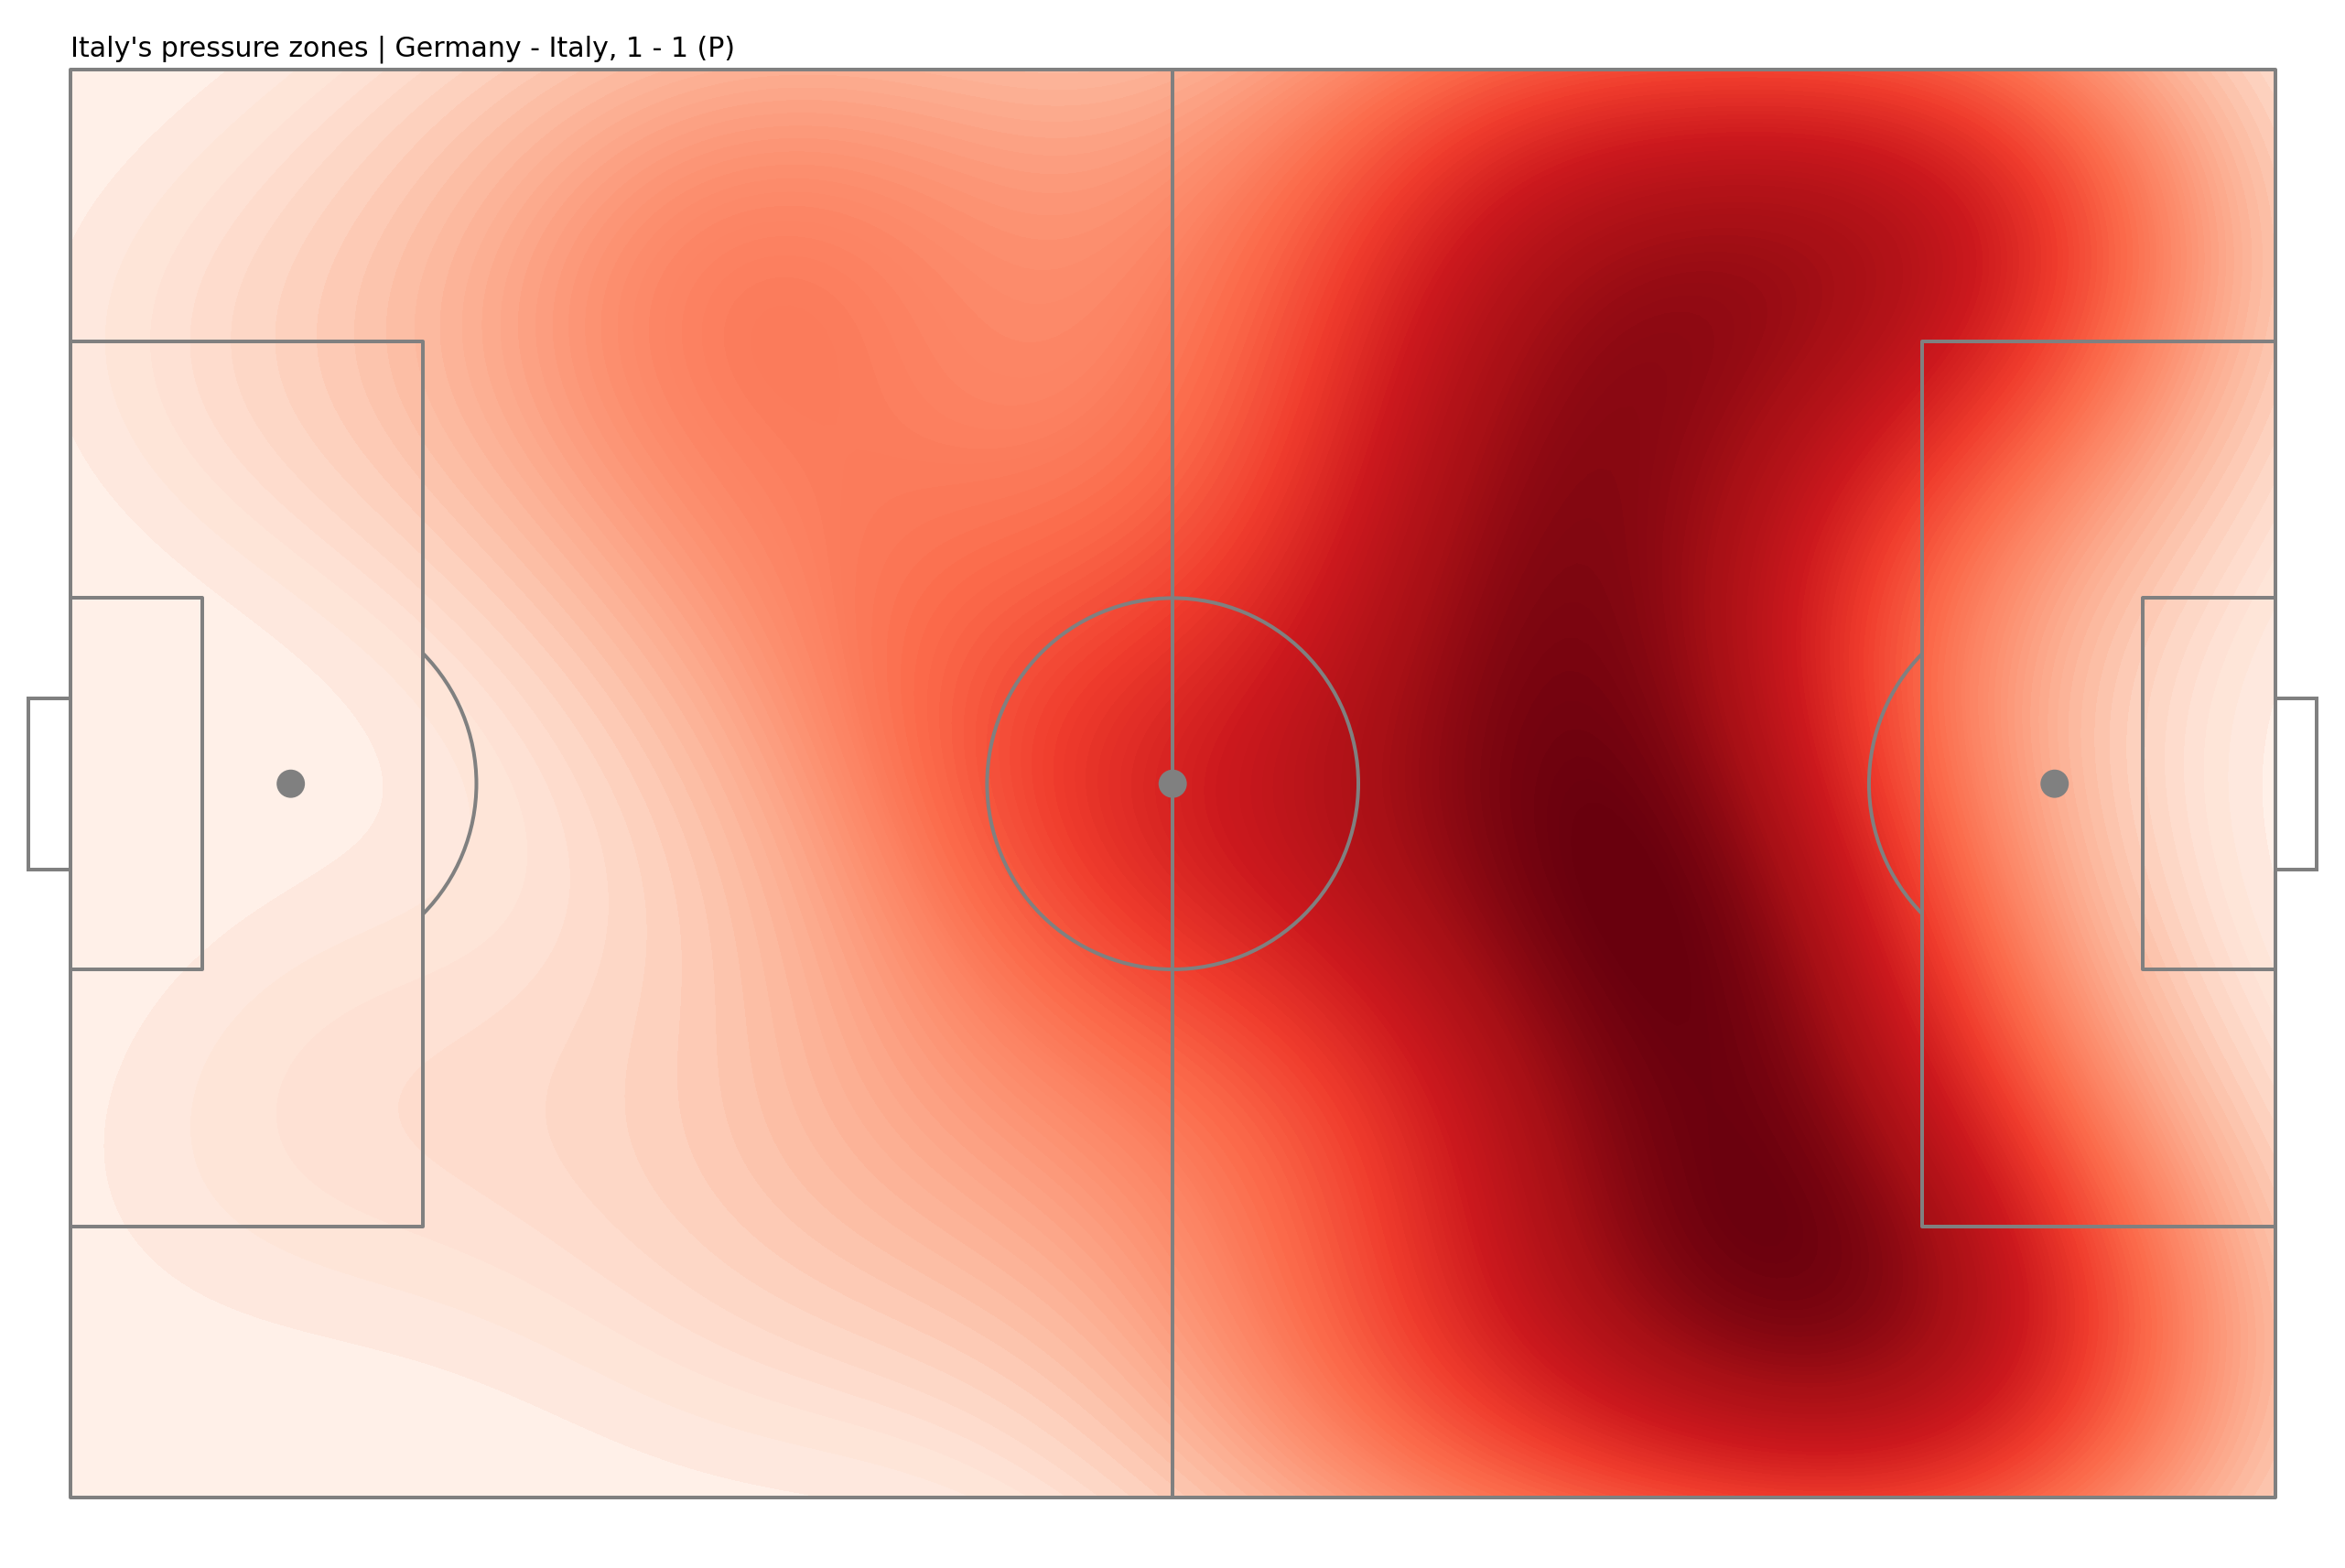

In [165]:
pitch = Pitch(pitch_type='wyscout', line_zorder=2, pitch_color='white', line_color='gray',
              goal_type='box', goal_alpha=1, linewidth=2, spot_scale=0.006)
fig, ax = pitch.draw(figsize=(20, 12))
kdeplot = pitch.kdeplot(positions_df.x, positions_df.y, ax=ax, cmap='Reds', shade=True, levels=100,
                        shade_lowest=True)
ax.text(0, -1, f"Italy's pressure zones | {euro_matches[match_id]['label']}", fontsize=15)
plt.show()

In [166]:
match_label = euro_matches[match_id]['label']
file_name = f"{match_label.split(',')[0].replace('-','_').replace(' ','').lower()}_pressure_zones_{team_name.lower()}"
fig.savefig(f'figures/{file_name}.png', dpi=300)

#### Heatmap

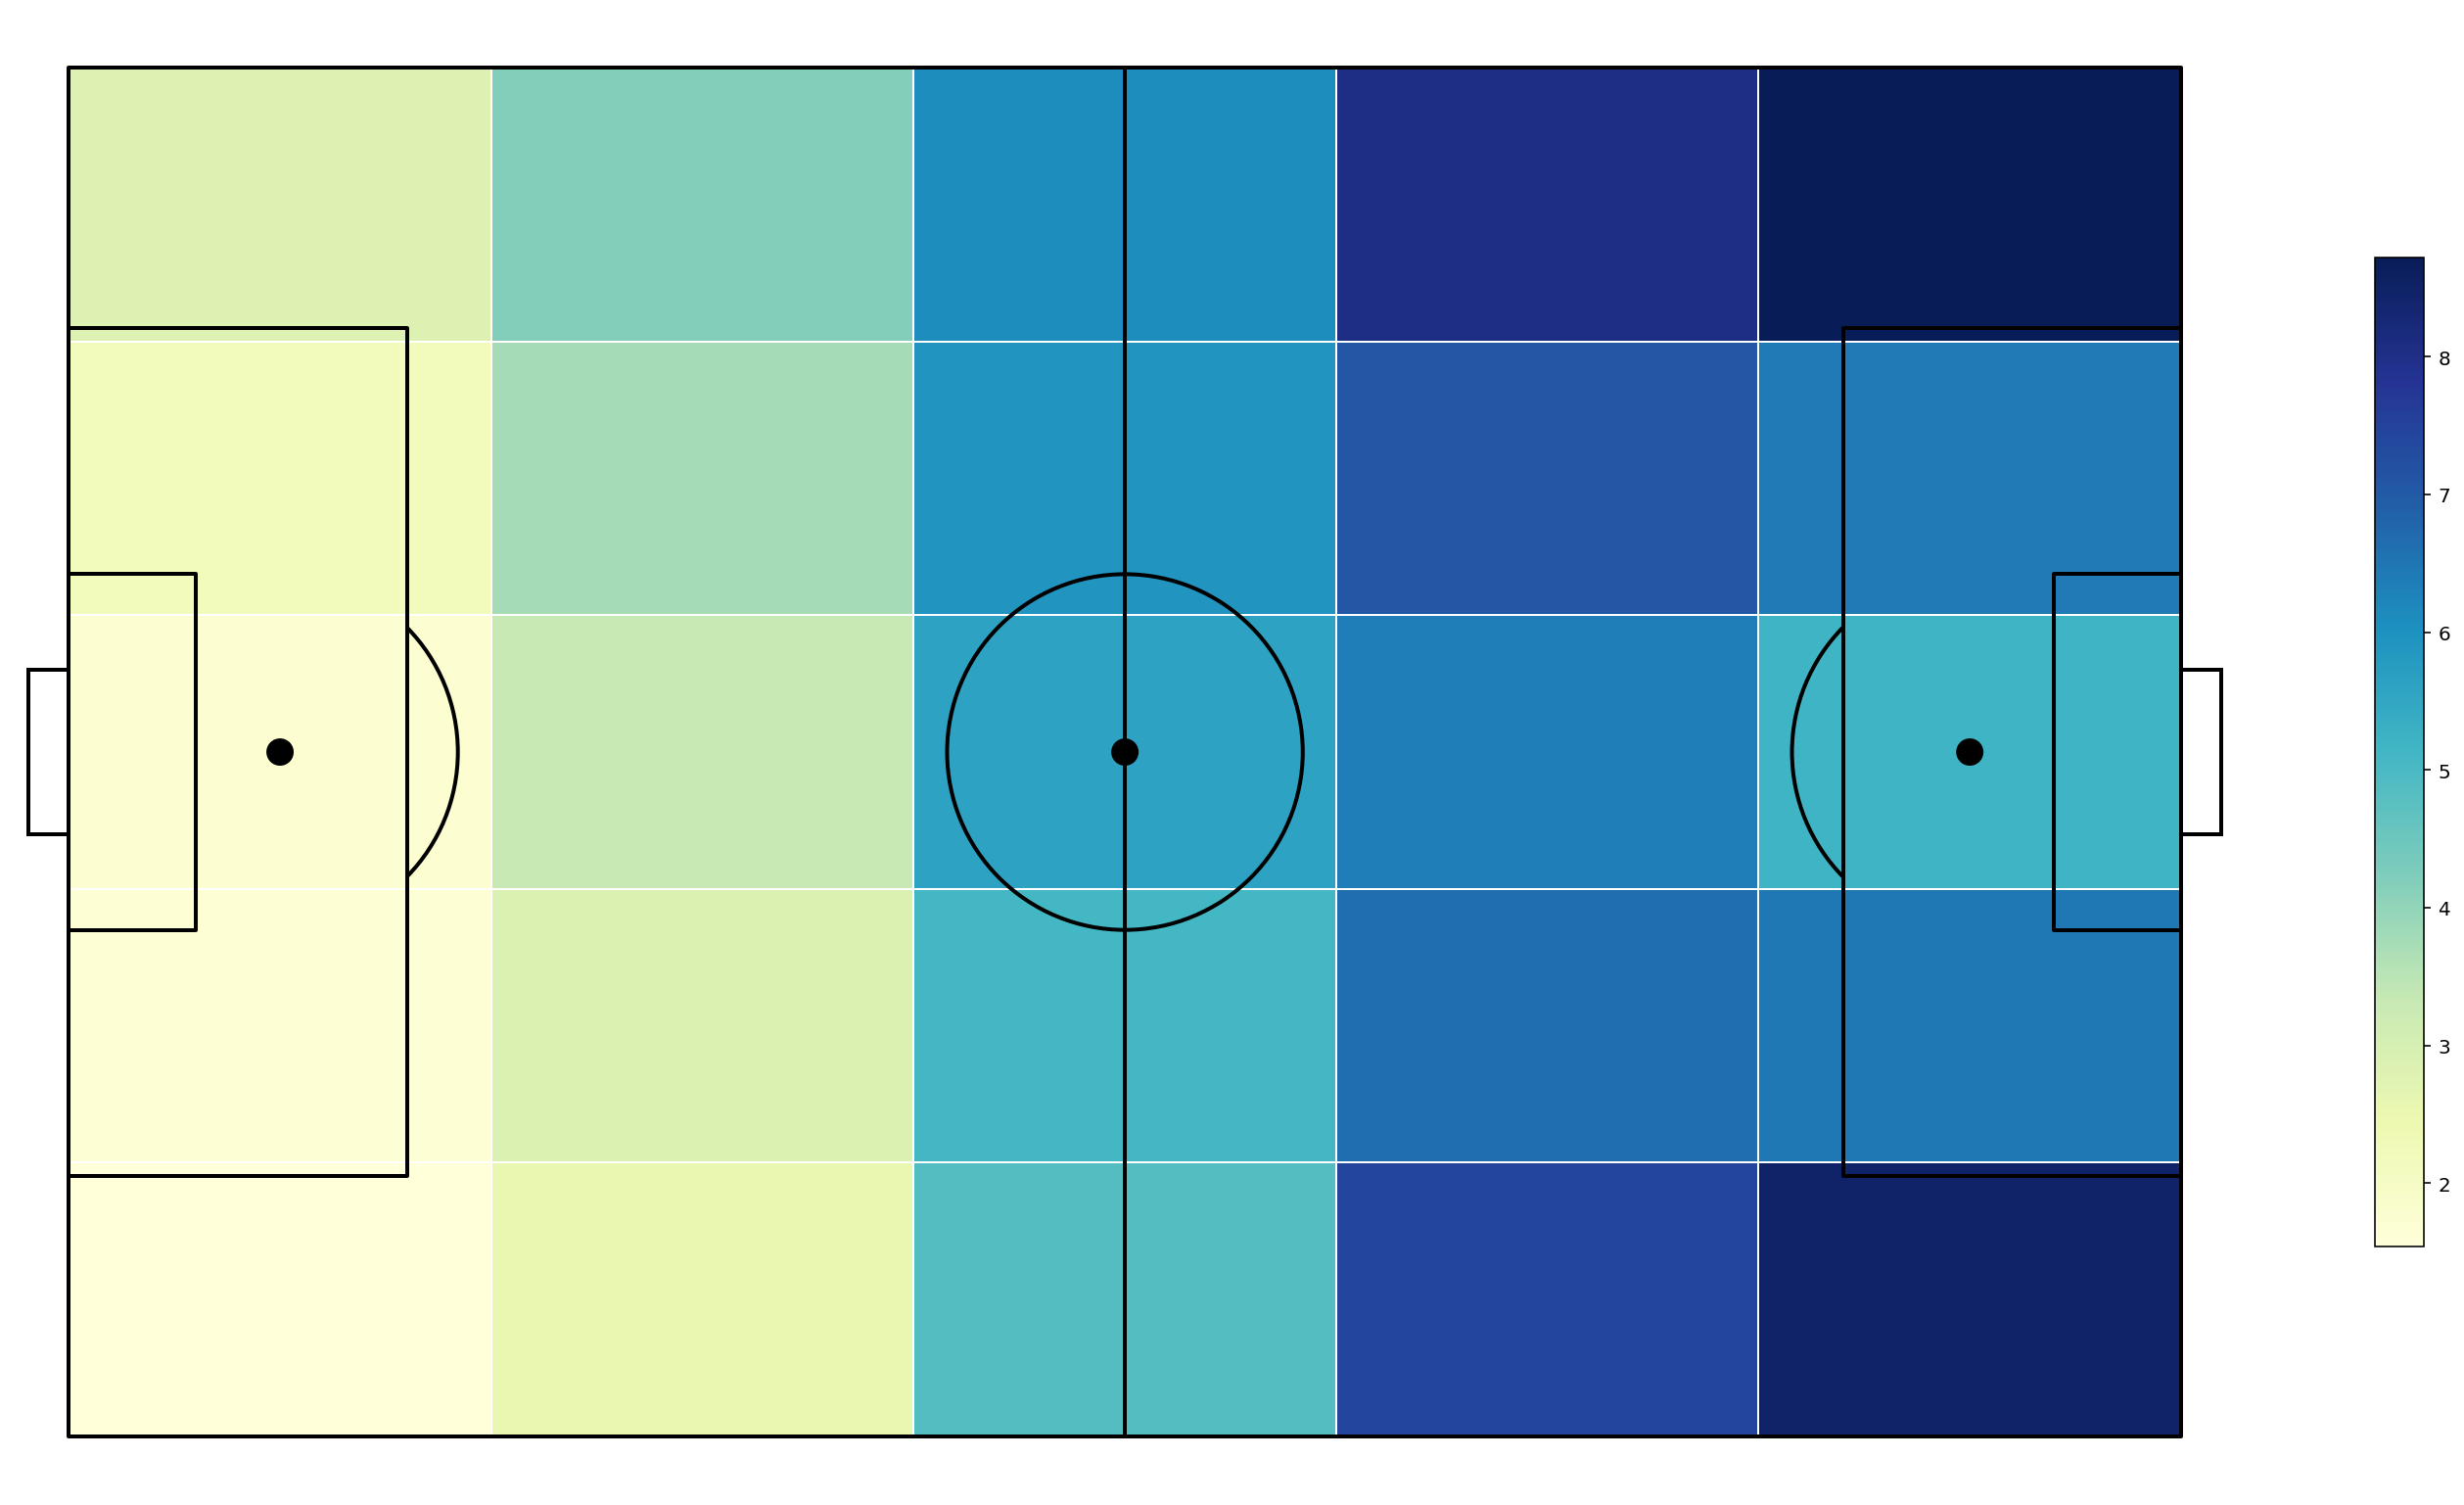

In [33]:
from scipy.ndimage import gaussian_filter
pitch = Pitch(pitch_type='wyscout', line_zorder=2, pitch_color='white', line_color='black',
              goal_type='box', goal_alpha=1, linewidth=2, spot_scale=0.006)
# draw
fig, ax = pitch.draw(figsize=(20, 12))
fig.set_facecolor('white')
bin_statistic = pitch.bin_statistic(positions_df.x, positions_df.y, statistic='count', bins=(5, 5))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='YlGnBu', edgecolors='white')
# Add the colorbar and format off-white
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('black')
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')
plt.show()

## Giorgio Chiellini

### Select Chiellini's events

In [92]:
player_lastname = 'Chiellini'

In [93]:
player_id = players_df.loc[players_df['lastName']==player_lastname, 'wyId'].values[0]

In [98]:
player_events = []
for event in events:
    if event['playerId'] == player_id:
        player_events.append(event)

In [97]:
player_events_df = pd.DataFrame(player_events)
player_events_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,3,Throw in,[{'id': 1801}],20461,"[{'y': 0, 'x': 31}, {'y': 16, 'x': 70}]",1694415,Free Kick,3757,1H,33.958365,36,88369266
1,8,Simple pass,[{'id': 1801}],20461,"[{'y': 19, 'x': 38}, {'y': 58, 'x': 22}]",1694415,Pass,3757,1H,44.088321,85,88369273
2,1,Ground defending duel,"[{'id': 702}, {'id': 1801}]",20461,"[{'y': 8, 'x': 17}, {'y': 0, 'x': 15}]",1694415,Duel,3757,1H,157.841676,12,88369305
3,8,Simple pass,[{'id': 1801}],20461,"[{'y': 45, 'x': 43}, {'y': 29, 'x': 62}]",1694415,Pass,3757,1H,197.301426,85,88369325
4,8,High pass,[{'id': 1802}],20461,"[{'y': 26, 'x': 56}, {'y': 100, 'x': 75}]",1694415,Pass,3757,1H,302.354128,83,88369371


In [104]:
print(f"{player_lastname} has been involved in {len(player_events)} events in {len(player_events_df.matchId.unique())} matches")

Chiellini has been involved in 360 events in 4 matches


### Select defensive events

In [109]:
player_events_df.eventName.value_counts()

Pass                  215
Duel                   80
Others on the ball     30
Free Kick              29
Foul                    4
Shot                    1
Offside                 1
Name: eventName, dtype: int64

In [113]:
defensive_events = []
for event in player_events:
    if event['eventName'] in ['Duel', 'Foul']:
        defensive_events.append(event)
print(f"{player_lastname} was involved in {len(defensive_events)} defensive events")

Chiellini was involved in 84 defensive events


In [123]:
type_defensive_events = list(player_events_df.loc[player_events_df['eventName'].isin(['Duel','Foul']),
                                                  'subEventName'].unique())
type_defensive_events

['Ground defending duel',
 'Air duel',
 'Ground loose ball duel',
 'Ground attacking duel',
 'Foul']

In [130]:
player_events_df.loc[player_events_df['subEventName']=='Foul',]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
59,2,Foul,[{'id': 1702}],20461,"[{'y': 29, 'x': 42}, {'y': 20, 'x': 46}]",1694415,Foul,3757,2H,1197.120227,20,88370594
131,2,Foul,[],20461,"[{'y': 14, 'x': 60}, {'y': 16, 'x': 61}]",1694416,Foul,3757,2H,409.516878,20,88659566
140,2,Foul,[],20461,"[{'y': 73, 'x': 67}, {'y': 74, 'x': 62}]",1694416,Foul,3757,2H,764.103491,20,88659683
359,2,Foul,[],20461,"[{'y': 10, 'x': 7}, {'y': 9, 'x': 15}]",1694436,Foul,3757,E2,564.090487,20,89883661


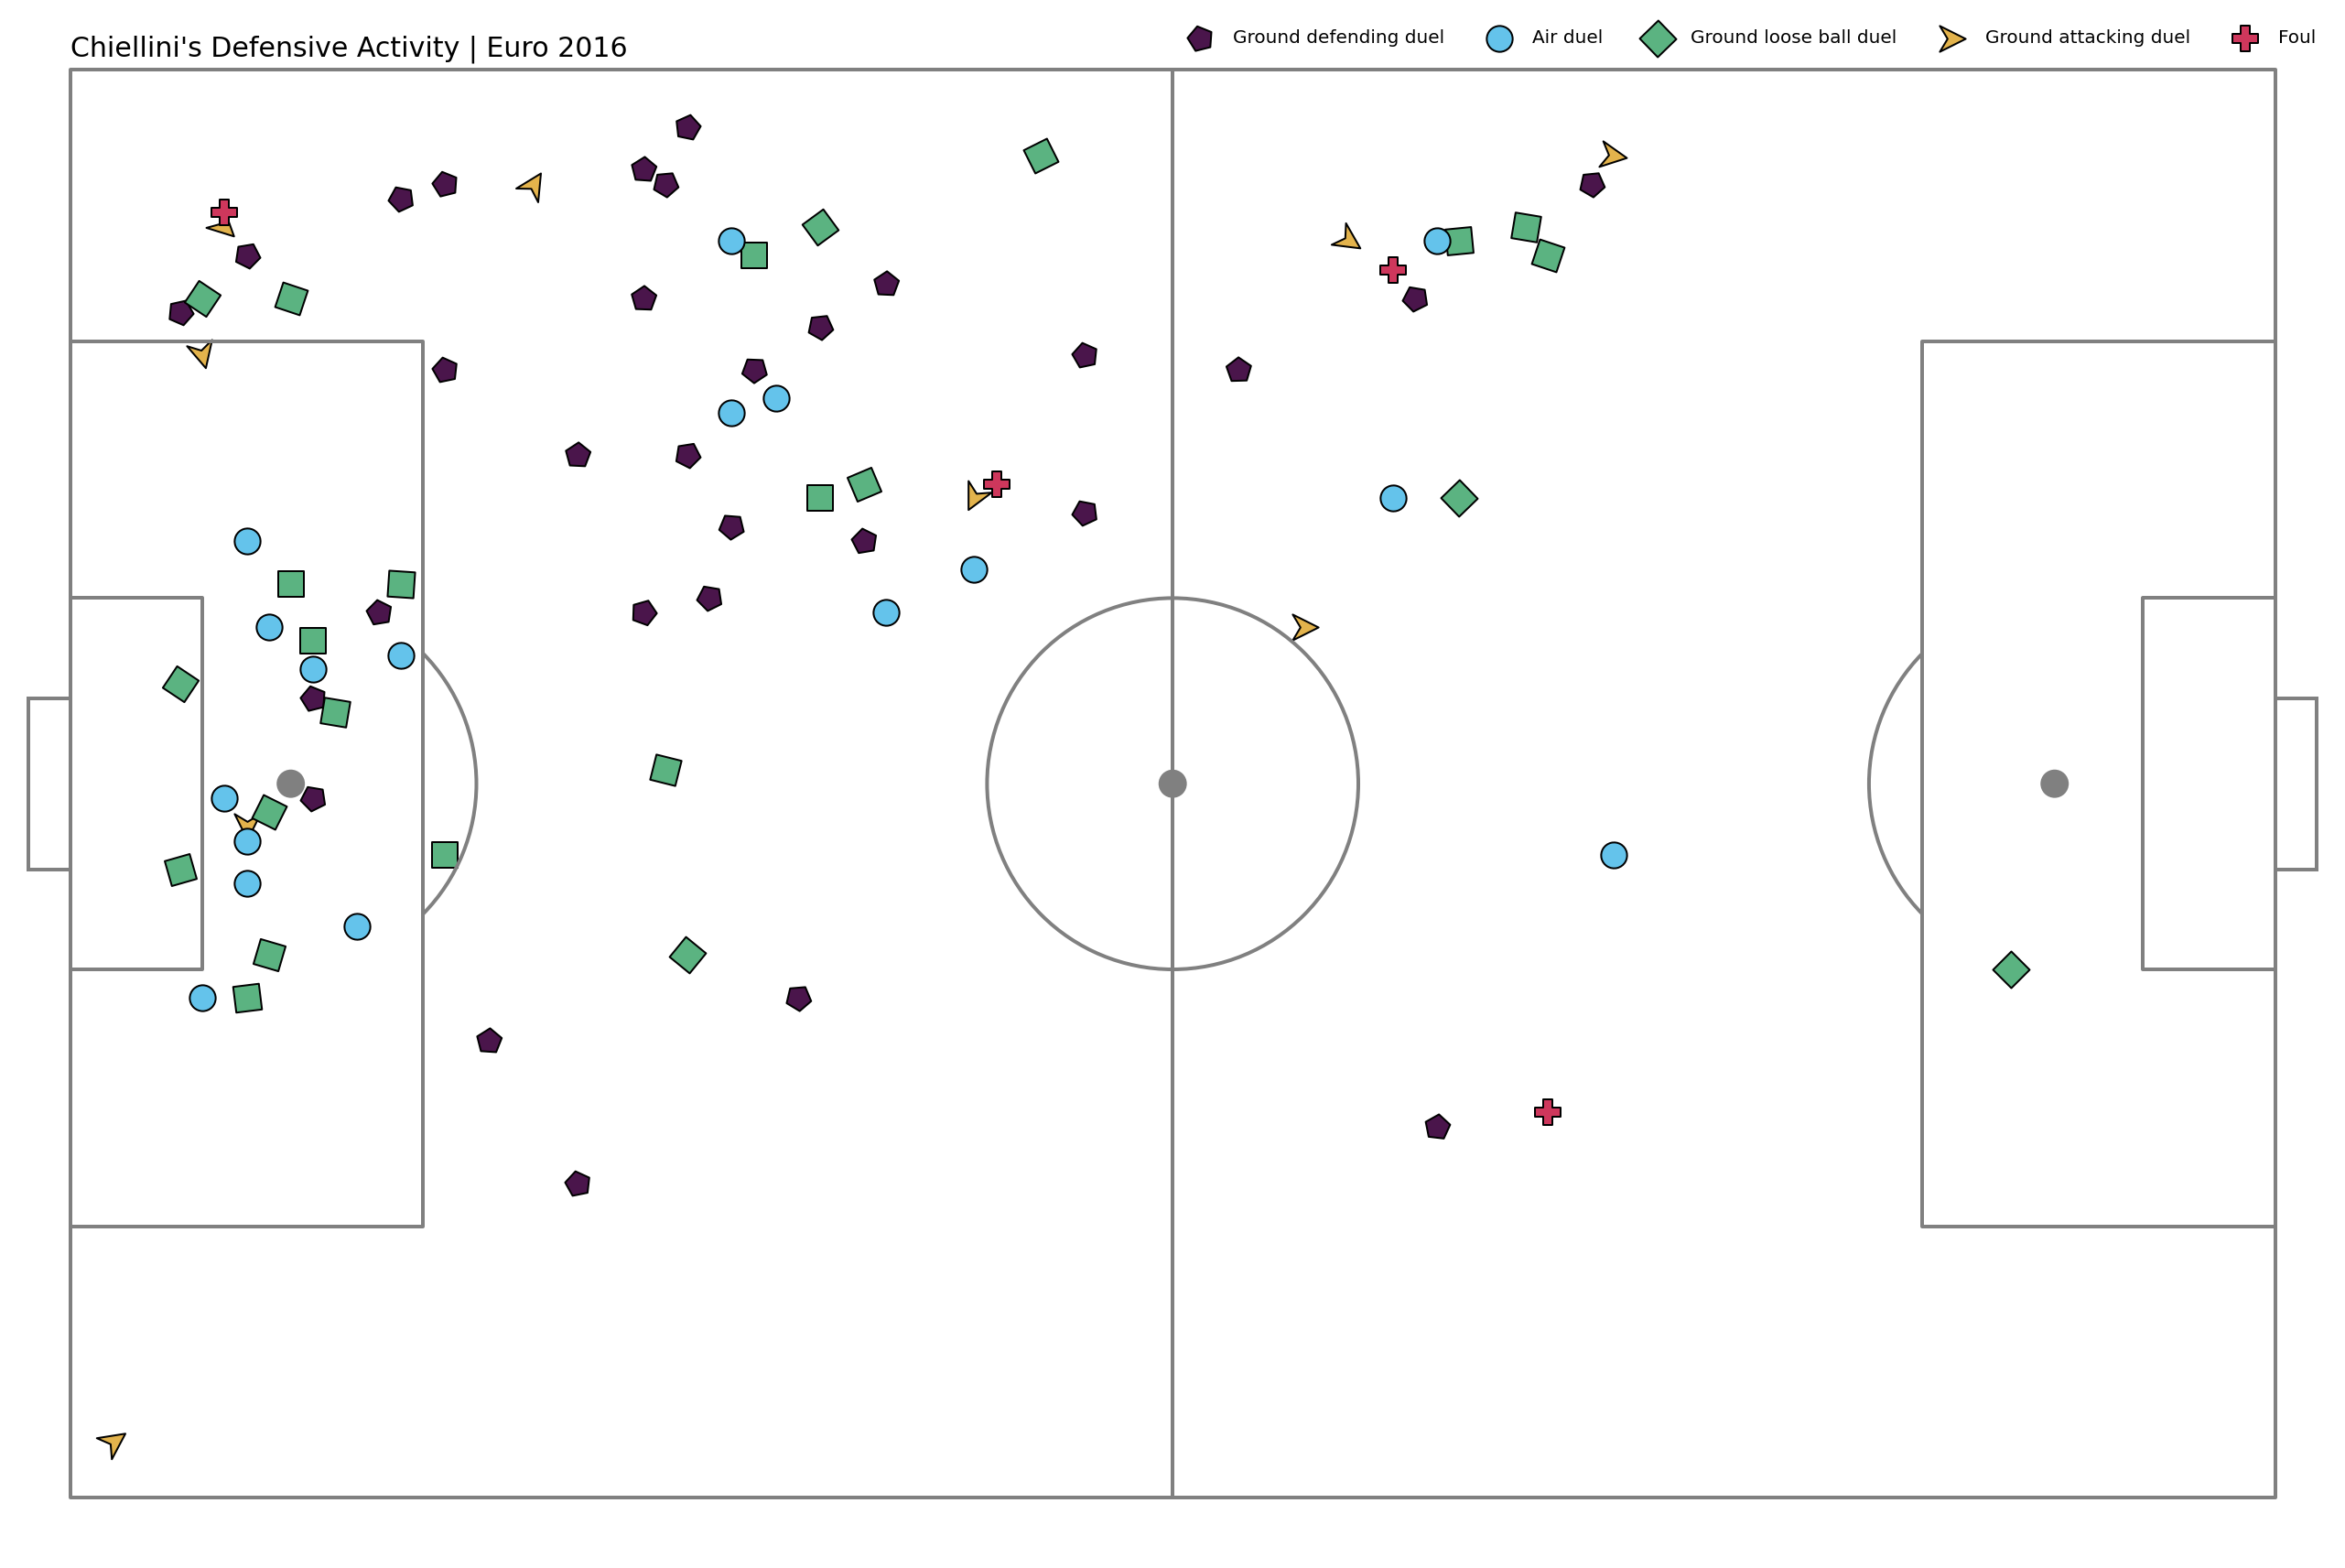

In [163]:
from mplsoccer.scatterutils import arrowhead_marker
event_makers = {
    'Ground defending duel': {'marker': 'p', 'color': '#4A154B', 'edge_color': 'black'},
    'Air duel': {'marker': 'o', 'color': '#64C3EB', 'edge_color': 'black'},
    'Ground loose ball duel': {'marker': 's', 'color': '#5BB381', 'edge_color': 'black'},
    'Ground attacking duel': {'marker': arrowhead_marker, 'color': '#E3B34C', 'edge_color': 'black'},
    'Foul': {'marker': 'P', 'color': '#CE375C', 'edge_color': 'black'}
}
pitch = Pitch(pitch_type='wyscout', line_zorder=2, pitch_color='white', line_color='gray',
              goal_type='box', goal_alpha=1, linewidth=2, spot_scale=0.006)
fig, ax = pitch.draw(figsize=(20, 12))
legends_added = []
for event in defensive_events:
    start_x, start_y = event['positions'][0]['x'], event['positions'][0]['y']
    end_x, end_y = event['positions'][1]['x'], event['positions'][1]['y']
    angle, distance = pitch.calculate_angle_and_distance(start_x, start_y, end_x, end_y,
                                                         standardized=False, degrees=True)
    event_attrs = {
        's':200,
        'edgecolors': event_makers[event['subEventName']]['edge_color'],
        'c': event_makers[event['subEventName']]['color'],
        'marker':event_makers[event['subEventName']]['marker'],
        'ax':ax
    }
    if event['subEventName'] != 'Foul':
        event_attrs['rotation_degrees'] = angle
    if event['subEventName'] not in legends_added:
        legends_added.append(event['subEventName'])
        event_attrs['label'] = event['subEventName']
    pitch.scatter(start_x, start_y, **event_attrs)
ax.text(0, -1, f"{player_lastname}'s Defensive Activity | Euro 2016", fontsize=15)
ax.legend(frameon=False, loc='upper right', ncol=5)
plt.show()

In [164]:
file_name = f"{player_lastname}_defensive_activity"
fig.savefig(f'figures/{file_name}.pdf', dpi=100)